# llc4320 drifters spectra: Lagrangian vs Eulerian

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd
from xhistogram.xarray import histogram
%matplotlib inline
from matplotlib import pyplot as plt
from cmocean import cm
import matplotlib.colors as colors

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5726858.datarmor0/parcels-502027/libparcels_random_10baa130-19e7-4f10-bd96-11fe631dd75f.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster(cores=28, processes=14) # necessary?
    w = cluster.scale(jobs=1)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

<Client: 'tcp://10.148.0.245:56235' processes=14 threads=28, memory=111.72 GiB>

________
# 1. Read LLC4320 spectra (both Eur. and Lag.)

In [4]:
# load spectra
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'
p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])

In [6]:
ds_L = (p.load_diagnostic('spectra_uv_T60_mean0_lat.zarr')
        .rename({'E':'E_Lagrangian', 'lat_bins': 'lat'})
       )

ds_E = (xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat.zarr'))
        .rename({'E_SSUV_T60': 'E_Eulerian', 'lat_bin': 'lat'})
       )

ds = xr.merge([ds_L, ds_E])
ds

<xarray.Dataset>
Dimensions:       (frequency: 1440, lat: 119)
Coordinates:
  * frequency     (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 55.5 56.5 57.5 58.5
Data variables:
    E_Lagrangian  (lat, frequency) float64 dask.array<chunksize=(60, 720), meta=np.ndarray>
    E_Eulerian    (frequency, lat) float64 dask.array<chunksize=(1440, 119), meta=np.ndarray>

In [7]:
ds_L_nomean = (p.load_diagnostic('spectra_uv_T60_mean1_lat.zarr')
        .rename({'E':'E_Lagrangian', 'lat_bins': 'lat'})
       )

ds_E_nomean = (xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_nomean_lat.zarr'))
        .rename({'E_SSUV_T60_nomean': 'E_Eulerian', 'lat_bin': 'lat'})
       )

ds_nomean = xr.merge([ds_L_nomean, ds_E_nomean])
ds_nomean

<xarray.Dataset>
Dimensions:       (frequency: 1440, lat: 119)
Coordinates:
  * frequency     (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 55.5 56.5 57.5 58.5
Data variables:
    E_Lagrangian  (lat, frequency) float64 dask.array<chunksize=(60, 720), meta=np.ndarray>
    E_Eulerian    (frequency, lat) float64 dask.array<chunksize=(1440, 119), meta=np.ndarray>

# 2. Read real drifter spectra

In [10]:
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds_raw = xr.open_zarr(data_dir+'E_drifter_raw.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
ds_linear_window = xr.open_zarr(data_dir+'E_drifter_linear_window.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
E_drifter = ds_linear_window.E_drifter_linear_window
#E_drifter = ds_raw.E_drifter_raw
E_drifter = E_drifter.assign_coords(lat=E_drifter.lat_bins) 
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifter.lat_bins))
f_cpd_drifter = f_drifter*86400/2./np.pi
E_drifter_interp = E_drifter.interp(lat_bins = ds.lat,freq_time= ds.frequency/86400)
E_drifter_interp

<xarray.DataArray 'E_drifter_linear_window' (lat: 119, frequency: 1440)>
dask.array<dask_aware_interpnd, shape=(119, 1440), dtype=float64, chunksize=(119, 1440), chunktype=numpy.ndarray>
Coordinates:
    freq_cpd           (frequency) float64 dask.array<chunksize=(1440,), meta=np.ndarray>
    freq_time_spacing  float64 ...
  * lat                (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
    lat_bins           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
    freq_time          (frequency) float64 -0.0001389 -0.0001387 ... 0.0001387
  * frequency          (frequency) float64 -12.0 -11.98 -11.97 ... 11.97 11.98

In [11]:
E_drifter_raw = ds_raw.E_drifter_raw
E_drifter_raw = E_drifter_raw.assign_coords(lat=E_drifter_raw.lat_bins) 
E_drifter_raw_interp = E_drifter_raw.interp(lat_bins = ds.lat,freq_time= ds.frequency/86400)
E_drifter_raw_interp

<xarray.DataArray 'E_drifter_raw' (lat: 119, frequency: 1440)>
dask.array<dask_aware_interpnd, shape=(119, 1440), dtype=float64, chunksize=(119, 1440), chunktype=numpy.ndarray>
Coordinates:
    freq_cpd           (frequency) float64 dask.array<chunksize=(1440,), meta=np.ndarray>
    freq_time_spacing  float64 ...
  * lat                (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
    lat_bins           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
    freq_time          (frequency) float64 -0.0001389 -0.0001387 ... 0.0001387
  * frequency          (frequency) float64 -12.0 -11.98 -11.97 ... 11.97 11.98

____________
## Rotary spectra

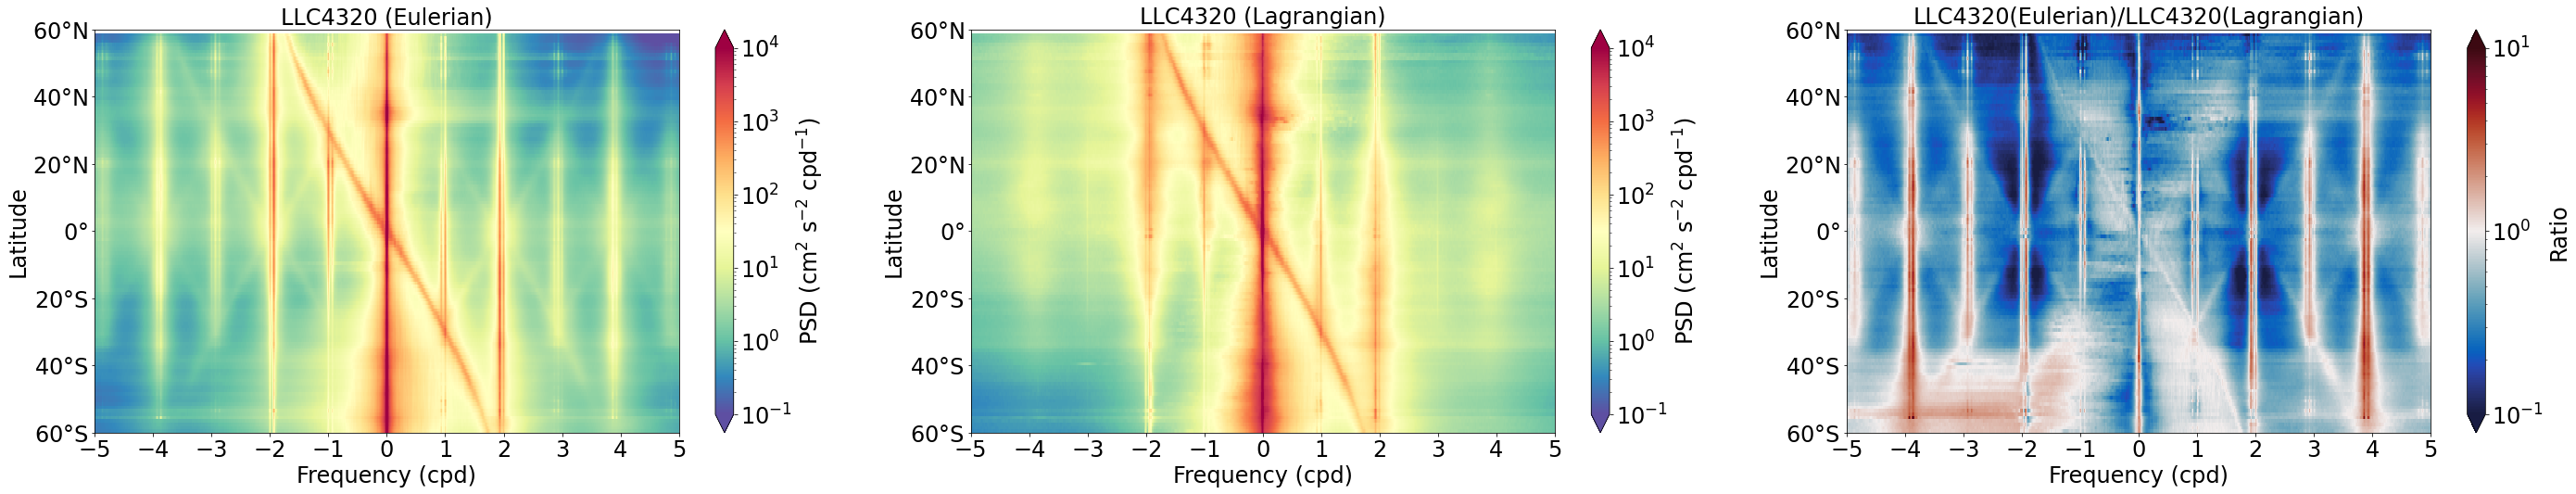

In [12]:
font_size = 24
fig, ax = plt.subplots(figsize=(48,8))

# LLC4320 Eulerian
ax = plt.subplot(1,3,1)
cax = (ds['E_Eulerian']*86400/6).plot.pcolormesh(ax=ax, x='frequency', y='lat', cmap = 'Spectral_r', norm=colors.LogNorm(vmin=1e-1, vmax=1e4), add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD (cm$^2$ s$^{-2}$ cpd$^{-1}$)', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320 (Eulerian)',fontsize=font_size)

# LLC420 Lagrangian
ax = plt.subplot(1,3,2)
cax = (ds['E_Lagrangian']*86400/6).plot.pcolormesh(ax=ax, x='frequency', y='lat', cmap = 'Spectral_r', norm=colors.LogNorm(vmin=1e-1, vmax=1e4), add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD (cm$^2$ s$^{-2}$ cpd$^{-1}$)', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
# add coriolis frequency
ax.set_title('LLC4320 (Lagrangian)',fontsize=font_size)

# Ratio
ax = plt.subplot(1,3,3)
cax = (ds['E_Eulerian']/ds['E_Lagrangian']).plot.pcolormesh(ax=ax, x='frequency', y='lat', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('LLC4320(Eulerian)/LLC4320(Lagrangian)',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Rotary_spectra_LLC_comparison.png')

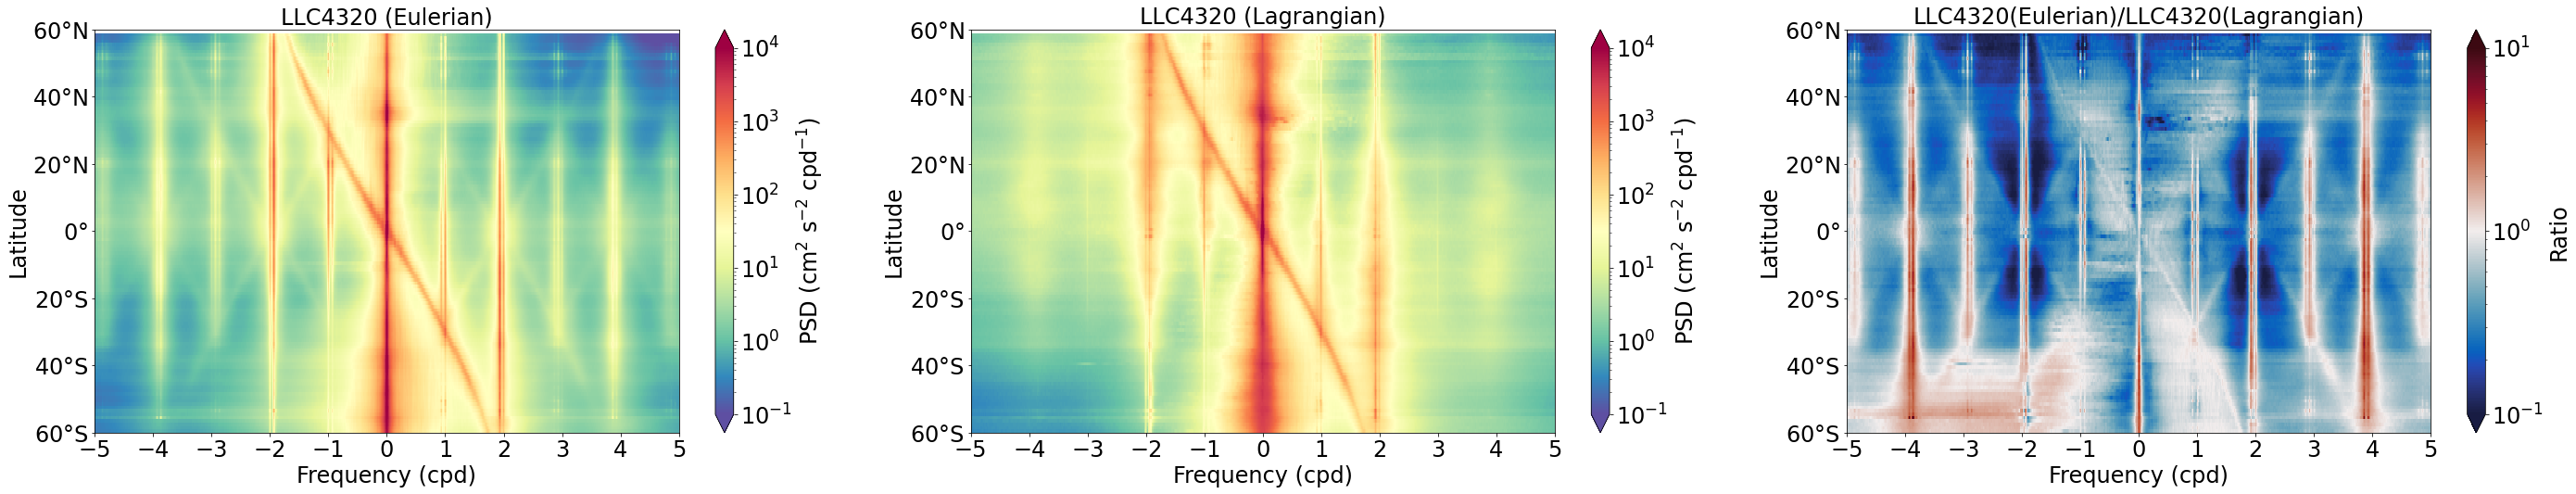

In [13]:
font_size = 24
fig, ax = plt.subplots(figsize=(48,8))

# LLC4320 Eulerian
ax = plt.subplot(1,3,1)
cax = (ds_nomean['E_Eulerian']*86400/6).plot.pcolormesh(ax=ax, x='frequency', y='lat', cmap = 'Spectral_r', norm=colors.LogNorm(vmin=1e-1, vmax=1e4), add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD (cm$^2$ s$^{-2}$ cpd$^{-1}$)', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320 (Eulerian)',fontsize=font_size)

# LLC420 Lagrangian
ax = plt.subplot(1,3,2)
cax = (ds_nomean['E_Lagrangian']*86400/6).plot.pcolormesh(ax=ax, x='frequency', y='lat', cmap = 'Spectral_r', norm=colors.LogNorm(vmin=1e-1, vmax=1e4), add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD (cm$^2$ s$^{-2}$ cpd$^{-1}$)', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
# add coriolis frequency
ax.set_title('LLC4320 (Lagrangian)',fontsize=font_size)

# Ratio
ax = plt.subplot(1,3,3)
cax = (ds_nomean['E_Eulerian']/ds_nomean['E_Lagrangian']).plot.pcolormesh(ax=ax, x='frequency', y='lat', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('LLC4320(Eulerian)/LLC4320(Lagrangian)',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Rotary_spectra_LLC_nomean_comparison.png')

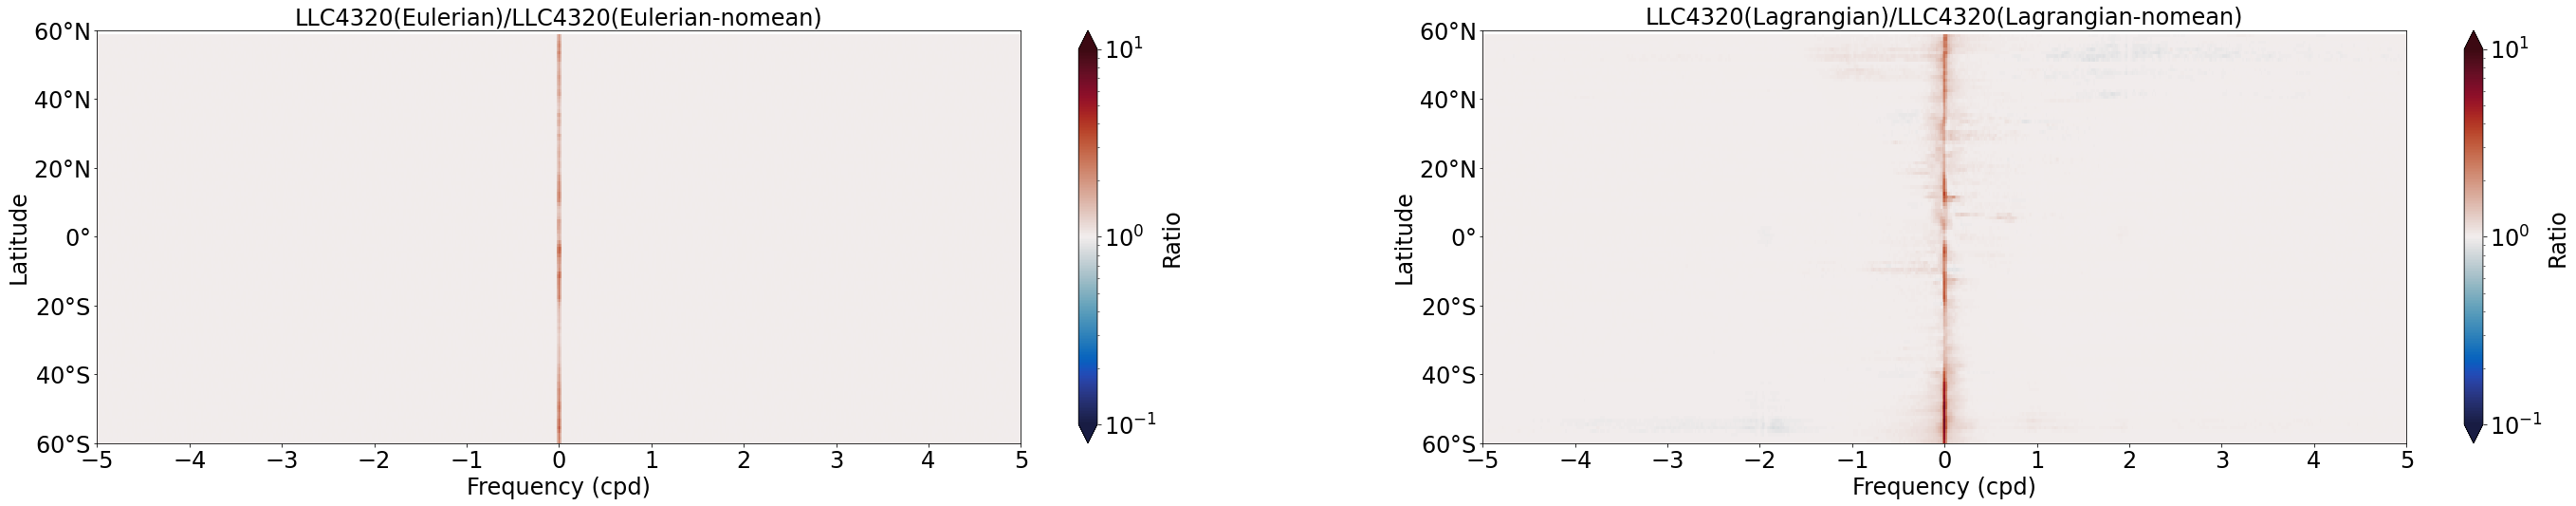

In [14]:
font_size = 24
fig, ax = plt.subplots(figsize=(48,8))

# LLC420 Lagrangian
ax = plt.subplot(1,2,1)
cax = (ds['E_Eulerian']/ds_nomean['E_Eulerian']).plot.pcolormesh(ax=ax, x='frequency', y='lat', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('LLC4320(Eulerian)/LLC4320(Eulerian-nomean)',fontsize=font_size)

# Ratio
ax = plt.subplot(1,2,2)
cax = (ds['E_Lagrangian']/ds_nomean['E_Lagrangian']).plot.pcolormesh(ax=ax, x='frequency', y='lat', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('LLC4320(Lagrangian)/LLC4320(Lagrangian-nomean)',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Rotary_spectra_LLC_nomean_comparison.png')

Text(0.5, 1.0, 'Drifter (drogued)')

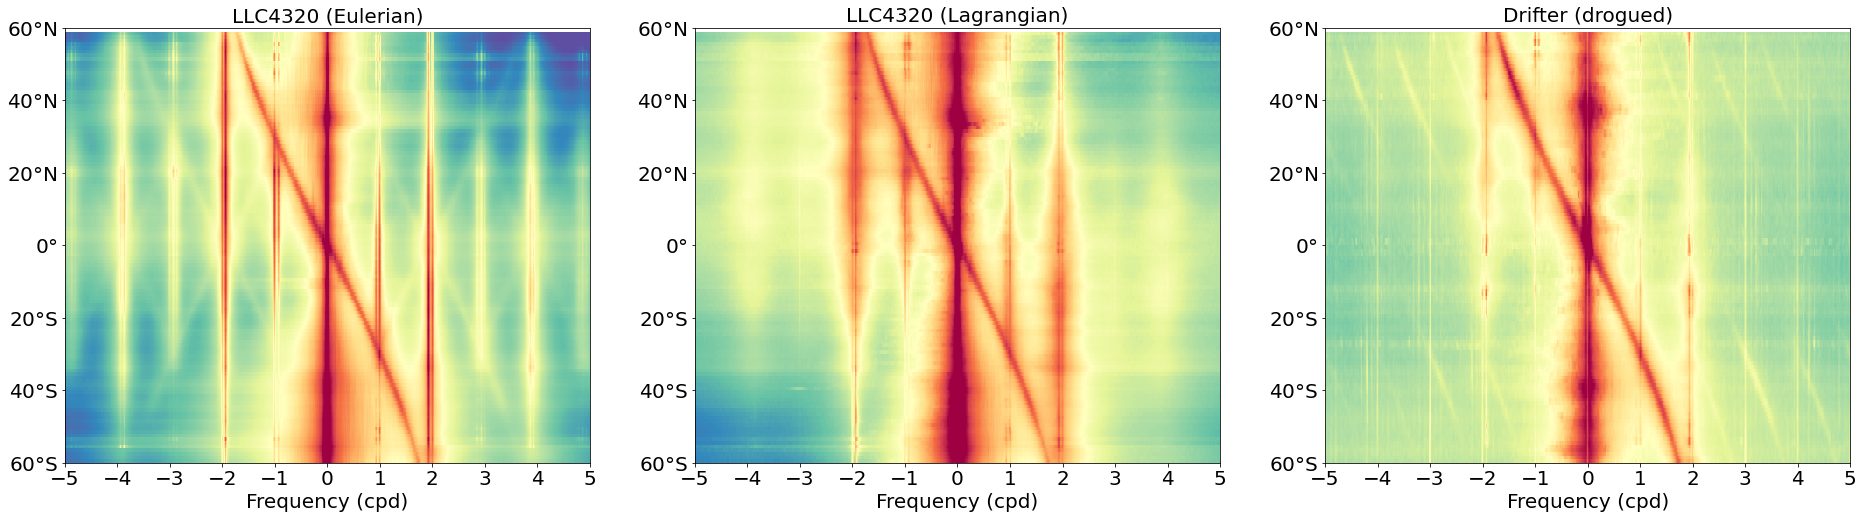

In [15]:
font_size = 20

fig, ax = plt.subplots(figsize=(32,8))

# LLC4320 Eulerian
ax = plt.subplot(1,3,1)
cax = np.log10(ds_nomean['E_Eulerian']).plot.pcolormesh(ax=ax, vmin=-5, vmax=-1, x='frequency', y='lat', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
#cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
#cbar.ax.tick_params(labelsize=font_size)
#cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('LLC4320 (Eulerian)',fontsize=font_size)


# LLC420 Lagrangian
ax = plt.subplot(1,3,2)
cax = np.log10(ds_nomean['E_Lagrangian']).plot.pcolormesh(ax=ax, vmin=-5, vmax=-1, x='frequency', y='lat', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
#cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
#cbar.ax.tick_params(labelsize=font_size)
#cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
# add coriolis frequency
ax.set_title('LLC4320 (Lagrangian)',fontsize=font_size)


# Drifters
ax = plt.subplot(1,3,3)
cax = np.log10(E_drifter_interp/86400).plot.pcolormesh(ax=ax, vmin=-5, vmax=-1, x='frequency', y='lat', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
#cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
#cbar.ax.tick_params(labelsize=font_size)
#cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
# add coriolis frequency
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifter.lat_bins))
#ax.plot(f_drifter*86400./2./np.pi,f_drifter.lat_bins,'w--')
#ax.plot(-f_drifter*86400./2./np.pi,f_drifter.lat_bins,'--',color='dimgrey')
ax.set_title('Drifter (drogued)',fontsize=font_size)

#plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Rotary_spectra_LLC_drifter.png')


Text(0.5, 1.0, 'LLC4320(Lagrangian)/Drifter(drogued)')

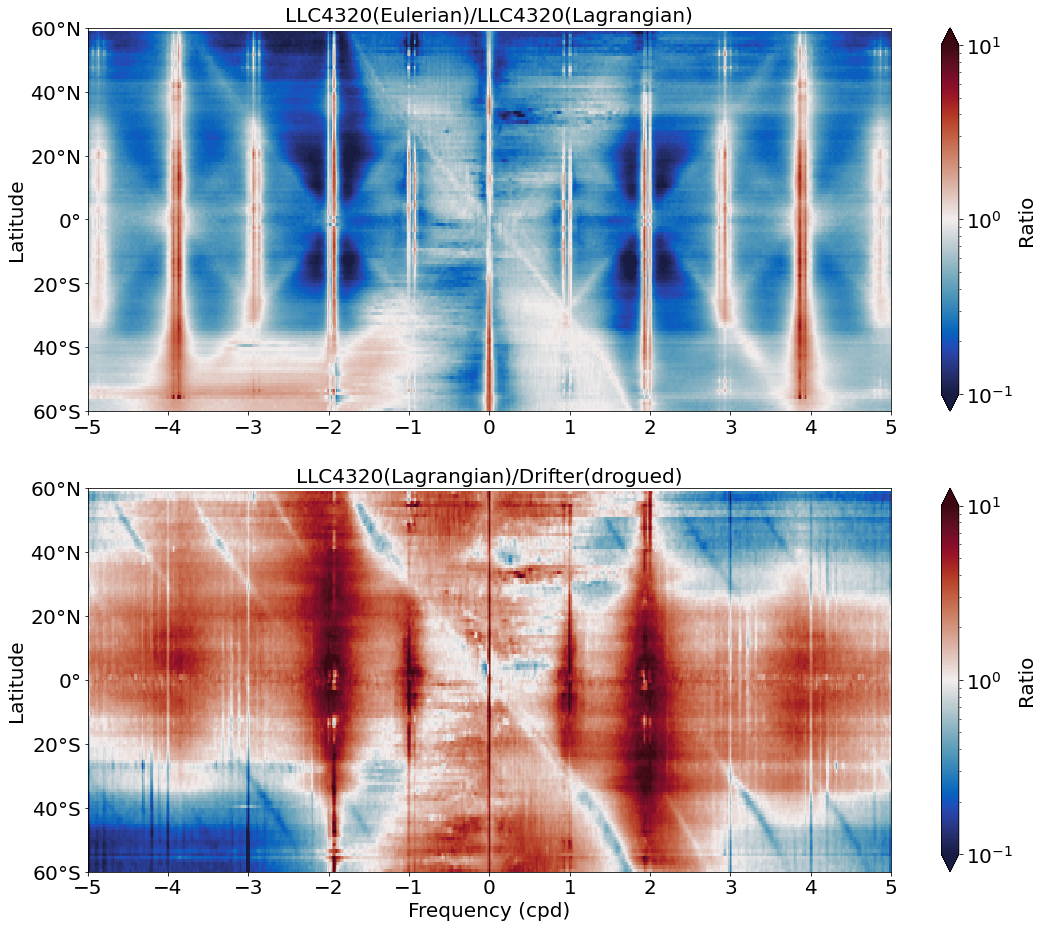

In [16]:
font_size = 20
fig, ax = plt.subplots(figsize=(18,24))

ax = plt.subplot(3,1,1)
cax = (ds_nomean['E_Eulerian']/ds_nomean['E_Lagrangian']).plot.pcolormesh(ax=ax, x='frequency', y='lat', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('LLC4320(Eulerian)/LLC4320(Lagrangian)',fontsize=font_size)

ax = plt.subplot(3,1,2)
cax = (ds_nomean['E_Lagrangian']/(E_drifter_interp.sortby('freq_time')/86400)).plot.pcolormesh(ax=ax, x='frequency', y='lat', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('LLC4320(Lagrangian)/Drifter(drogued)',fontsize=font_size)

#plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Rotary_spectra_LLC_drifter_ratio.png')

__________________
## Band-integrated energy

### 1. with mean

In [17]:
E_Lagrangian = ds.E_Lagrangian
E_Eulerian = ds.E_Eulerian
df=E_Eulerian.frequency[1]-E_Eulerian.frequency[0]

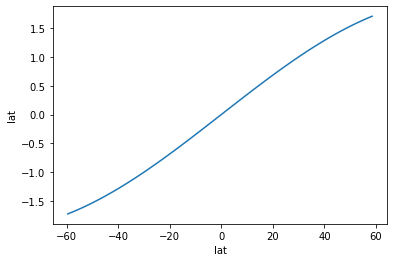

In [18]:
# Inertial frequency
f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_Eulerian.lat))
f_cpd_llc = f_llc*86400/2./np.pi
f_cpd_llc.plot()

In [19]:
E_KE_Lagrangian = (E_Lagrangian*df).sum(dim='frequency')
E_high_Lagrangian = (E_Lagrangian.where((abs(E_Lagrangian.frequency)>0.5) , other=0.)*df).sum(dim='frequency')

E_KE_Eulerian = (E_Eulerian*df).sum(dim='frequency')
E_high_Eulerian = (E_Eulerian.where((abs(E_Eulerian.frequency)>0.5) , other=0.)*df).sum(dim='frequency')

Text(0.5, 1.0, 'LLC4320 (Lagrangian)')

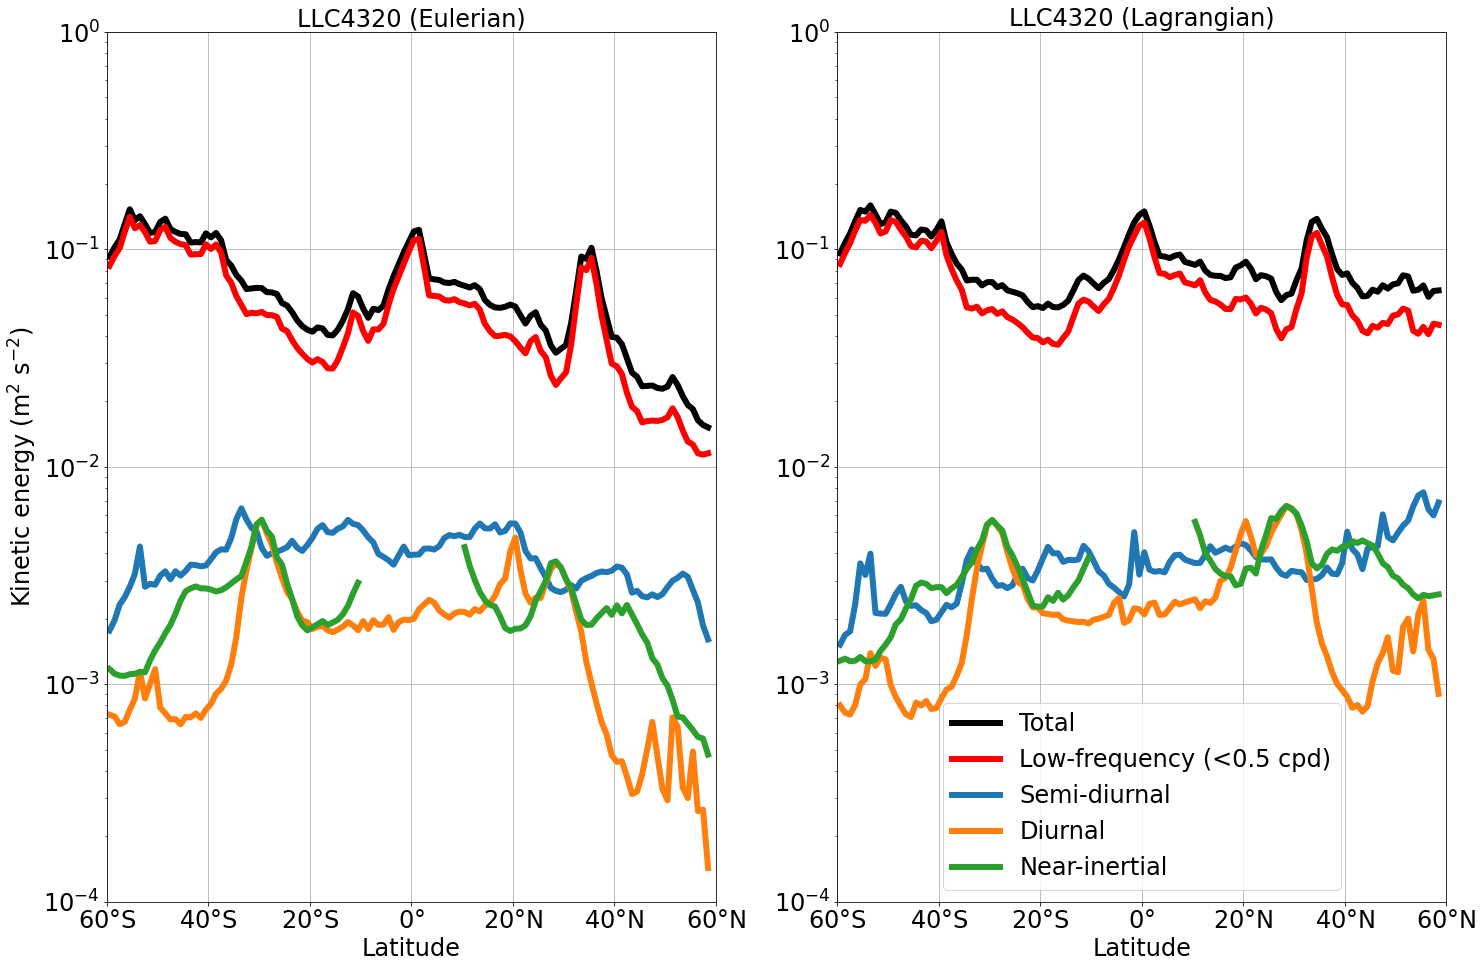

In [20]:
# compare each component by applying windowing
labels = ['Total', 'Low-frequency (<0.5 cpd)','High-frequency (>0.5 cpd)','Semi-diurnal', 'Diurnal', 'Near-inertial']
linewidth = 6
fontsize = 24

fig, ax = plt.subplots(figsize=(24,16))

ax = plt.subplot(1,2,1)
E_KE_Eulerian.plot(color='black', label=labels[0], linewidth=linewidth) # total energy
(E_KE_Eulerian - E_high_Eulerian).plot(color='red', label=labels[1], linewidth=linewidth) # total energy
#E_high_Eulerian.plot( label=labels[2], linewidth=linewidth)   # energy at low frequencies (> 5 day
(E_Eulerian.where((abs(E_Eulerian.frequency)>1.9) & (abs(E_Eulerian.frequency)<2.1) , other=0.)*df).sum(dim='frequency').plot(label=labels[3], linewidth=linewidth) # energy around semi-diurnal frequencies
(E_Eulerian.where((abs(E_Eulerian.frequency)>0.9) & (abs(E_Eulerian.frequency)<1.1) , other=0.)*df).sum(dim='frequency').plot(label=labels[4], linewidth=linewidth) # energy around diurnal frequencies
(E_Eulerian.where(abs(E_Eulerian.frequency+f_cpd_llc)<.1, other=0.)*df).sum(dim='frequency').where(abs(E_Eulerian.lat)>10).plot(label=labels[5], linewidth=linewidth) # energy around f
#ax.legend(prop={'size': fontsize}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_yscale('log')
ax.set_ylim([1e-4,1e0])
# Label, size
ax.set_xlabel('Latitude',fontsize=fontsize)
ax.set_ylabel('',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('LLC4320 (Eulerian)',fontsize=24)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': font_size})
ax.set_ylabel('Kinetic energy (m$^2$ s$^{-2}$)',fontsize=fontsize)

ax = plt.subplot(1,2,2)
E_KE_Lagrangian.plot(color='black', label=labels[0], linewidth=linewidth) # total energy
(E_KE_Lagrangian - E_high_Lagrangian).plot(color='red', label=labels[1], linewidth=linewidth) # total energy
#E_high_Lagrangian.plot(label=labels[2], linewidth=linewidth)   # energy at low frequencies (> 5 day
(E_Lagrangian.where((abs(E_Lagrangian.frequency)>1.9) & (abs(E_Lagrangian.frequency)<2.1) , other=0.)*df).sum(dim='frequency').plot(label=labels[3], linewidth=linewidth) # energy around semi-diurnal frequencies
(E_Lagrangian.where((abs(E_Lagrangian.frequency)>0.9) & (abs(E_Lagrangian.frequency)<1.1) , other=0.)*df).sum(dim='frequency').plot(label=labels[4], linewidth=linewidth) # energy around diurnal frequencies
(E_Lagrangian.where(abs(E_Lagrangian.frequency+f_cpd_llc)<.1, other=0.)*df).sum(dim='frequency').where(abs(E_Lagrangian.lat)>10).plot(label=labels[5], linewidth=linewidth) # energy around f
ax.legend(prop={'size': fontsize}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_yscale('log')
ax.set_ylim([1e-4,1e0])
# Label, size
ax.set_xlabel('Latitude',fontsize=fontsize)
#ax.set_ylabel('Kinetic energy (m$^2$ s$^{-2}$)',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('LLC4320 (Lagrangian)',fontsize=fontsize)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': font_size})

#plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_Eulerian_Lagrangian.png')

Text(0.5, 1.0, '')

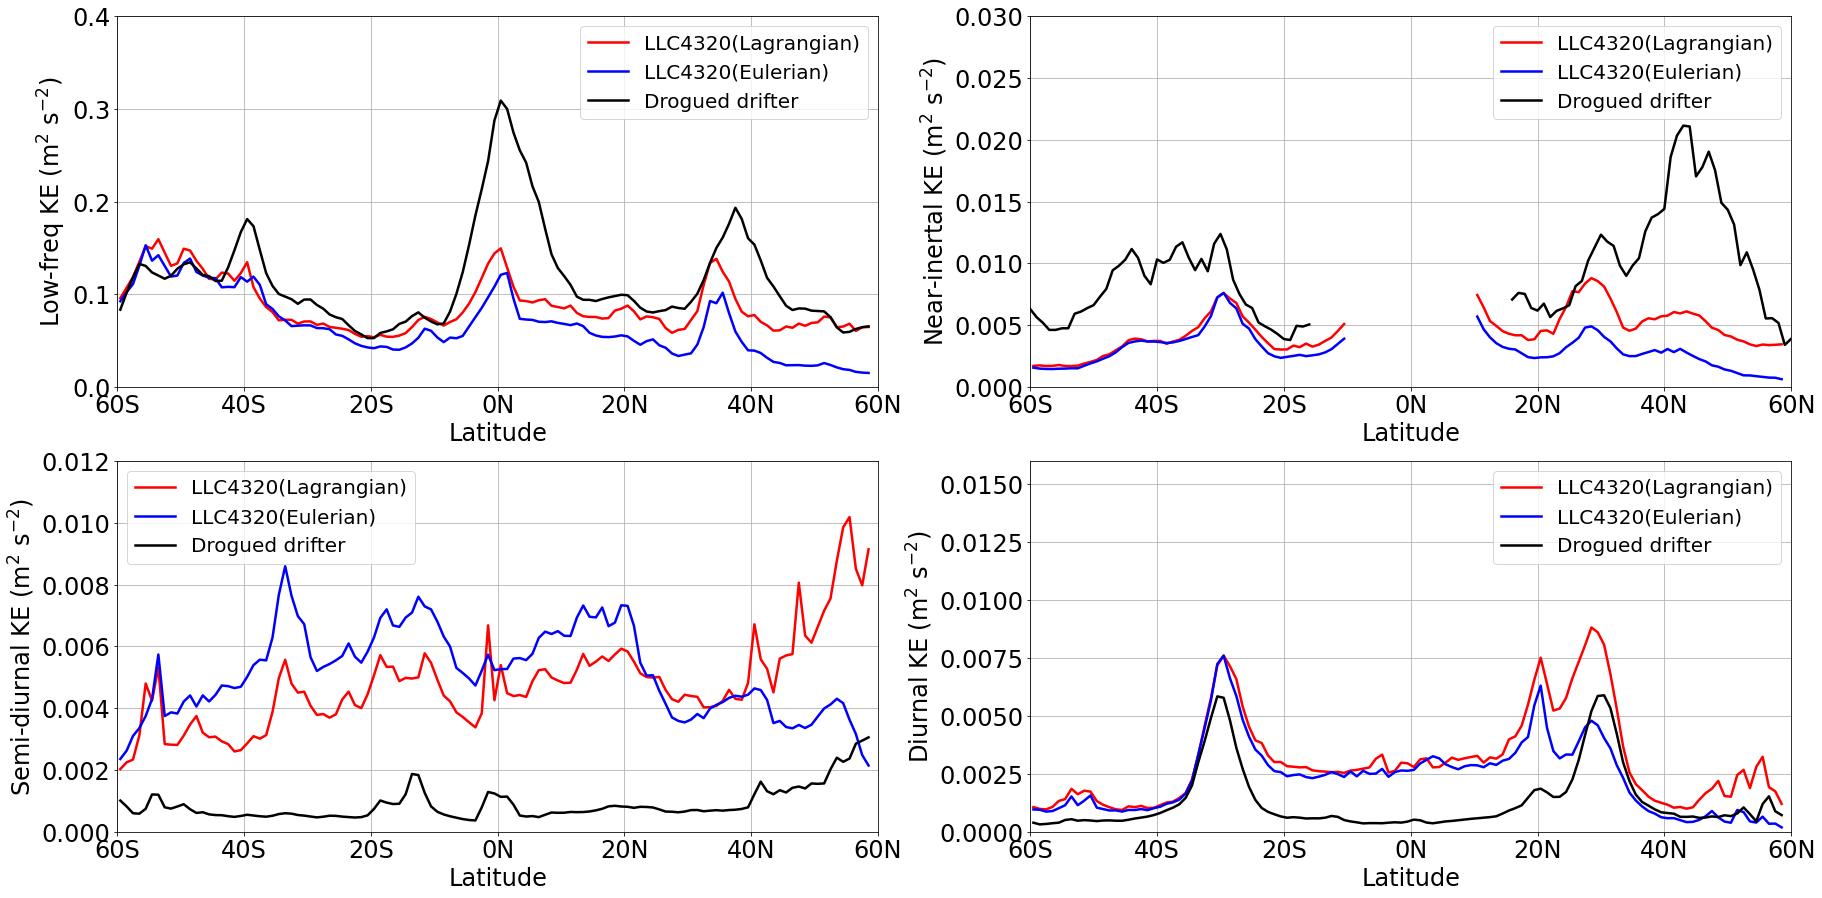

In [21]:
# compare each component by applying windowing
labels = ['LLC4320(Lagrangian)', 'LLC4320(Eulerian)', 'Drogued drifter']

#E_KE_drifter =  (E_drifter_interp*df/86400).sum(dim='frequency')
E_KE_drifter =  (E_drifter_raw_interp*df/86400).sum(dim='frequency')

fig, ax = plt.subplots(figsize=(30,15))

ax = plt.subplot(2,2,1)
(E_KE_Lagrangian).plot(color='red', label=labels[0], linewidth=2.5) # total energy
(E_KE_Eulerian).plot(color='blue', label=labels[1], linewidth=2.5) # total energy
E_KE_drifter.plot(color='black', label=labels[2], linewidth=2.5) # total energy
ax.legend(prop={'size': 20}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Low-freq KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('',fontsize=24)

ax = plt.subplot(2,2,2)
(4/3*E_Lagrangian.where(abs(E_Lagrangian.frequency+f_cpd_llc)<.1, other=0.)*df).sum(dim='frequency').where(abs(E_Lagrangian.lat)>10).plot(color='red', label=labels[0], linewidth=2.5) # energy around f
(4/3*E_Eulerian.where(abs(E_Eulerian.frequency+f_cpd_llc)<.1, other=0.)*df).sum(dim='frequency').where(abs(E_Eulerian.lat)>10).plot(color='blue', label=labels[1], linewidth=2.5) # energy around f
(8/3/86400*E_drifter.where(abs(E_drifter.freq_cpd+f_cpd_drifter)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E_drifter.lat_bins)>15).plot(color='black', label=labels[2], linewidth=2.5) # energy around f
ax.legend(prop={'size': 20}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.03])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Near-inertal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('',fontsize=24)

ax = plt.subplot(2,2,3)
(4/3*E_Lagrangian.where((abs(E_Lagrangian.frequency)>1.9) & (abs(E_Lagrangian.frequency)<2.1) , other=0.)*df).sum(dim='frequency').plot(color='red', label=labels[0], linewidth=2.5) # energy around semi-diurnal frequencies
(4/3*E_Eulerian.where((abs(E_Eulerian.frequency)>1.9) & (abs(E_Eulerian.frequency)<2.1) , other=0.)*df).sum(dim='frequency').plot(color='blue', label=labels[1], linewidth=2.5) # energy around semi-diurnal frequencies
(4/3/86400*E_drifter_interp.where((abs(E_drifter_interp.frequency)>1.9) & (abs(E_drifter_interp.frequency)<2.1) , other=0.)*df).sum(dim='frequency').plot(color='black', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
ax.legend(prop={'size': 20}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.012])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Semi-diurnal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('',fontsize=24)

ax = plt.subplot(2,2,4)
(4/3*E_Lagrangian.where((abs(E_Lagrangian.frequency)>0.9) & (abs(E_Lagrangian.frequency)<1.1) , other=0.)*df).sum(dim='frequency').plot(color='red', label=labels[0], linewidth=2.5) # energy around diurnal frequencies
(4/3*E_Eulerian.where((abs(E_Eulerian.frequency)>0.9) & (abs(E_Eulerian.frequency)<1.1) , other=0.)*df).sum(dim='frequency').plot(color='blue', label=labels[1], linewidth=2.5) # energy around diurnal frequencies
(4/3/86400*E_drifter_interp.where((abs(E_drifter_interp.frequency)>0.9) & (abs(E_drifter_interp.frequency)<1.1) , other=0.)*df).sum(dim='frequency').plot(color='black', label=labels[2], linewidth=2.5) # energy around diurnal frequencies
ax.legend(prop={'size': 20}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.016])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Diurnal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('',fontsize=24)


### 2. without mean

In [22]:
E_Lagrangian = ds_nomean.E_Lagrangian
E_Eulerian = ds_nomean.E_Eulerian
df=E_Eulerian.frequency[1]-E_Eulerian.frequency[0]

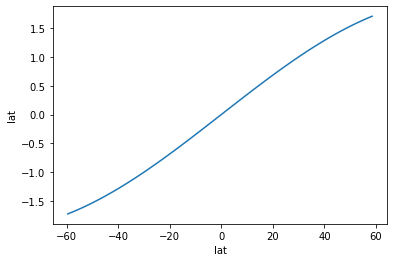

In [23]:
# Inertial frequency
f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_Eulerian.lat))
f_cpd_llc = f_llc*86400/2./np.pi
f_cpd_llc.plot()

In [24]:
E_KE_Lagrangian = (E_Lagrangian*df).sum(dim='frequency')
E_high_Lagrangian = (E_Lagrangian.where((abs(E_Lagrangian.frequency)>0.5) , other=0.)*df).sum(dim='frequency')

E_KE_Eulerian = (E_Eulerian*df).sum(dim='frequency')
E_high_Eulerian = (E_Eulerian.where((abs(E_Eulerian.frequency)>0.5) , other=0.)*df).sum(dim='frequency')

Text(0.5, 1.0, 'LLC4320 (Lagrangian)')

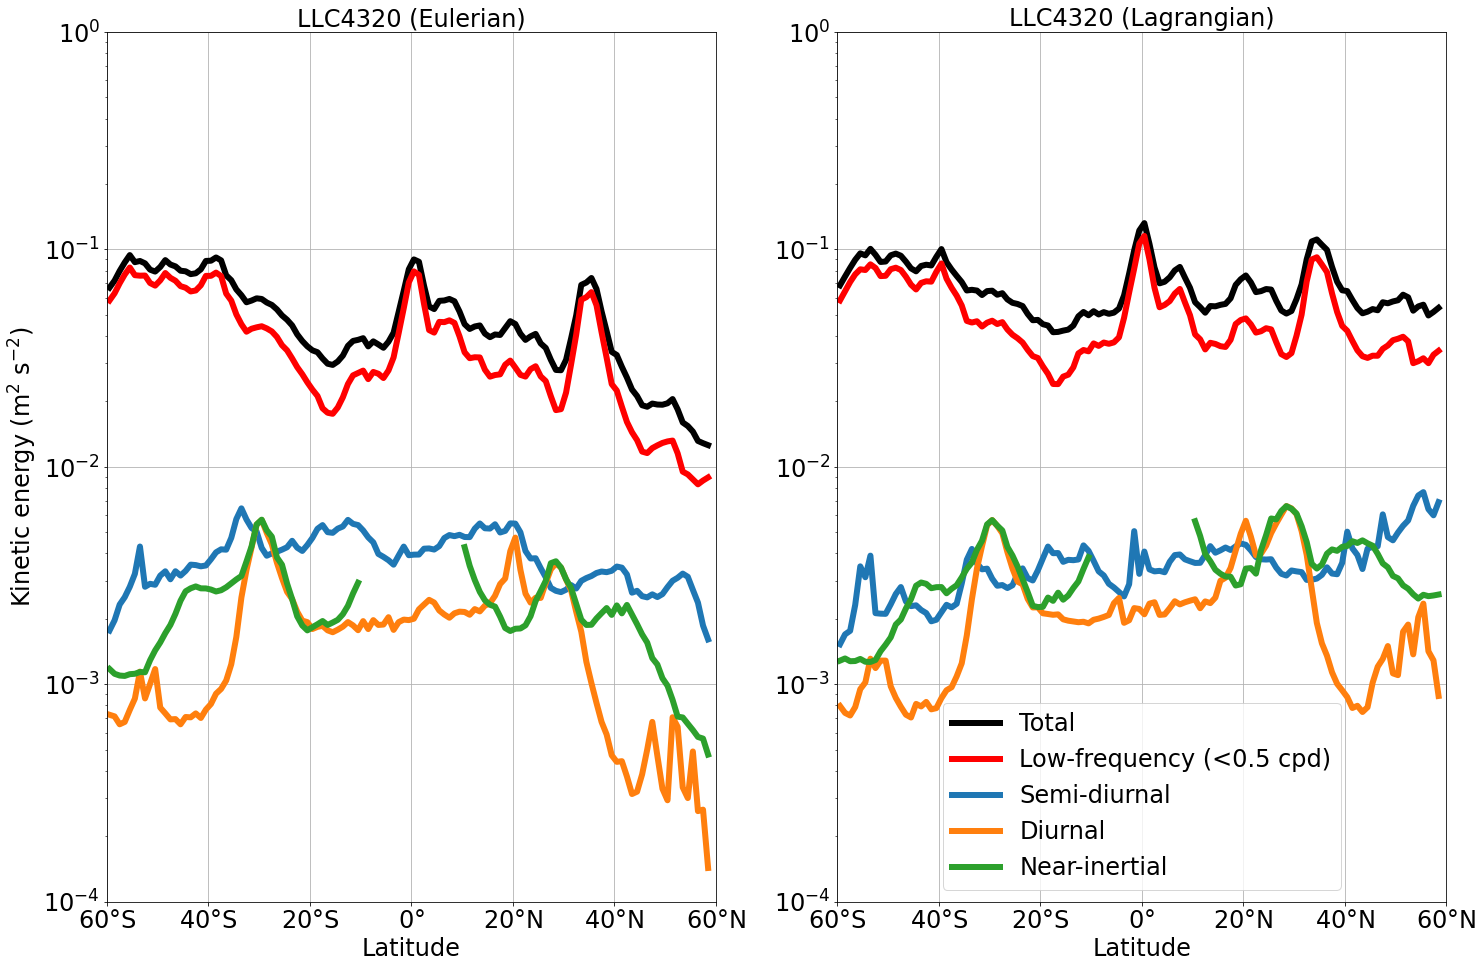

In [25]:
# compare each component by applying windowing
labels = ['Total', 'Low-frequency (<0.5 cpd)','High-frequency (>0.5 cpd)','Semi-diurnal', 'Diurnal', 'Near-inertial']
linewidth = 6
fontsize = 24

fig, ax = plt.subplots(figsize=(24,16))

ax = plt.subplot(1,2,1)
E_KE_Eulerian.plot(color='black', label=labels[0], linewidth=linewidth) # total energy
(E_KE_Eulerian - E_high_Eulerian).plot(color='red', label=labels[1], linewidth=linewidth) # total energy
#E_high_Eulerian.plot( label=labels[2], linewidth=linewidth)   # energy at low frequencies (> 5 day
(E_Eulerian.where((abs(E_Eulerian.frequency)>1.9) & (abs(E_Eulerian.frequency)<2.1) , other=0.)*df).sum(dim='frequency').plot(label=labels[3], linewidth=linewidth) # energy around semi-diurnal frequencies
(E_Eulerian.where((abs(E_Eulerian.frequency)>0.9) & (abs(E_Eulerian.frequency)<1.1) , other=0.)*df).sum(dim='frequency').plot(label=labels[4], linewidth=linewidth) # energy around diurnal frequencies
(E_Eulerian.where(abs(E_Eulerian.frequency+f_cpd_llc)<.1, other=0.)*df).sum(dim='frequency').where(abs(E_Eulerian.lat)>10).plot(label=labels[5], linewidth=linewidth) # energy around f
#ax.legend(prop={'size': fontsize}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_yscale('log')
ax.set_ylim([1e-4,1e0])
# Label, size
ax.set_xlabel('Latitude',fontsize=fontsize)
ax.set_ylabel('',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('LLC4320 (Eulerian)',fontsize=24)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': font_size})
ax.set_ylabel('Kinetic energy (m$^2$ s$^{-2}$)',fontsize=fontsize)

ax = plt.subplot(1,2,2)
E_KE_Lagrangian.plot(color='black', label=labels[0], linewidth=linewidth) # total energy
(E_KE_Lagrangian - E_high_Lagrangian).plot(color='red', label=labels[1], linewidth=linewidth) # total energy
#E_high_Lagrangian.plot(label=labels[2], linewidth=linewidth)   # energy at low frequencies (> 5 day
(E_Lagrangian.where((abs(E_Lagrangian.frequency)>1.9) & (abs(E_Lagrangian.frequency)<2.1) , other=0.)*df).sum(dim='frequency').plot(label=labels[3], linewidth=linewidth) # energy around semi-diurnal frequencies
(E_Lagrangian.where((abs(E_Lagrangian.frequency)>0.9) & (abs(E_Lagrangian.frequency)<1.1) , other=0.)*df).sum(dim='frequency').plot(label=labels[4], linewidth=linewidth) # energy around diurnal frequencies
(E_Lagrangian.where(abs(E_Lagrangian.frequency+f_cpd_llc)<.1, other=0.)*df).sum(dim='frequency').where(abs(E_Lagrangian.lat)>10).plot(label=labels[5], linewidth=linewidth) # energy around f
ax.legend(prop={'size': fontsize}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_yscale('log')
ax.set_ylim([1e-4,1e0])
# Label, size
ax.set_xlabel('Latitude',fontsize=fontsize)
#ax.set_ylabel('Kinetic energy (m$^2$ s$^{-2}$)',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('LLC4320 (Lagrangian)',fontsize=fontsize)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': font_size})

#plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_Eulerian_Lagrangian_nomean.png')

Text(0.5, 1.0, '')

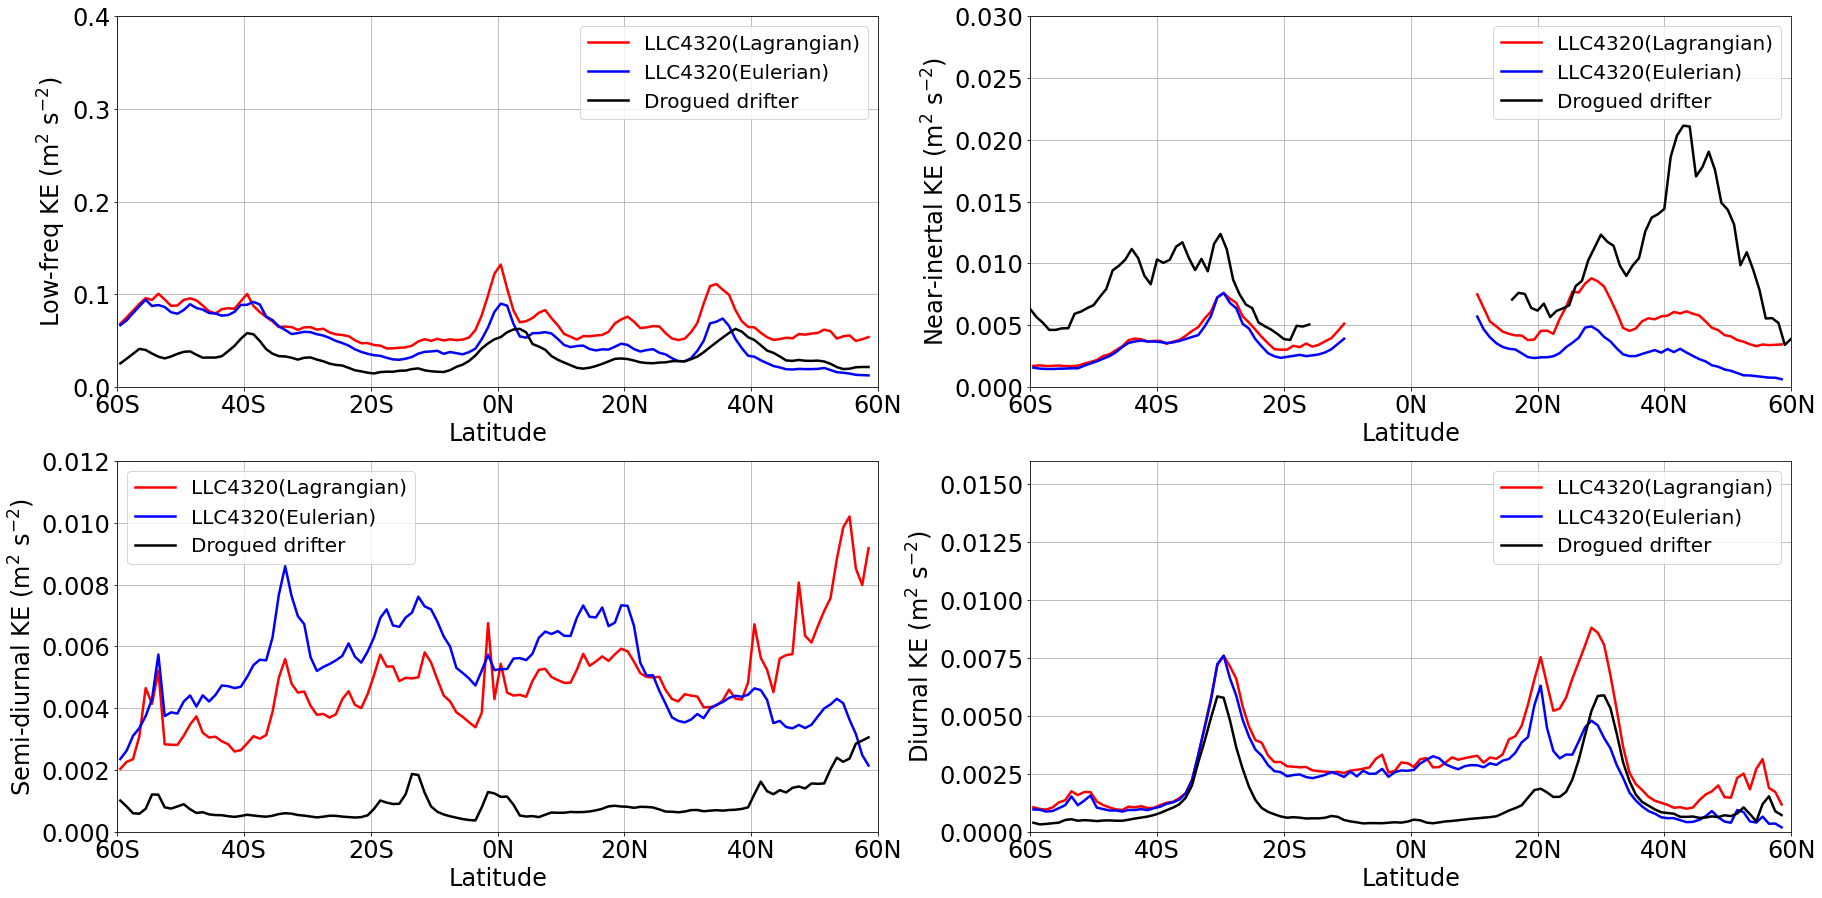

In [26]:
# compare each component by applying windowing
labels = ['LLC4320(Lagrangian)', 'LLC4320(Eulerian)', 'Drogued drifter']

E_KE_drifter =  (E_drifter_interp*df/86400).sum(dim='frequency')

fig, ax = plt.subplots(figsize=(30,15))

ax = plt.subplot(2,2,1)
(E_KE_Lagrangian).plot(color='red', label=labels[0], linewidth=2.5) # total energy
(E_KE_Eulerian).plot(color='blue', label=labels[1], linewidth=2.5) # total energy
E_KE_drifter.plot(color='black', label=labels[2], linewidth=2.5) # total energy
ax.legend(prop={'size': 20}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.4])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Low-freq KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('',fontsize=24)

ax = plt.subplot(2,2,2)
(4/3*E_Lagrangian.where(abs(E_Lagrangian.frequency+f_cpd_llc)<.1, other=0.)*df).sum(dim='frequency').where(abs(E_Lagrangian.lat)>10).plot(color='red', label=labels[0], linewidth=2.5) # energy around f
(4/3*E_Eulerian.where(abs(E_Eulerian.frequency+f_cpd_llc)<.1, other=0.)*df).sum(dim='frequency').where(abs(E_Eulerian.lat)>10).plot(color='blue', label=labels[1], linewidth=2.5) # energy around f
(8/3/86400*E_drifter.where(abs(E_drifter.freq_cpd+f_cpd_drifter)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E_drifter.lat_bins)>15).plot(color='black', label=labels[2], linewidth=2.5) # energy around f
ax.legend(prop={'size': 20}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.03])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Near-inertal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('',fontsize=24)

ax = plt.subplot(2,2,3)
(4/3*E_Lagrangian.where((abs(E_Lagrangian.frequency)>1.9) & (abs(E_Lagrangian.frequency)<2.1) , other=0.)*df).sum(dim='frequency').plot(color='red', label=labels[0], linewidth=2.5) # energy around semi-diurnal frequencies
(4/3*E_Eulerian.where((abs(E_Eulerian.frequency)>1.9) & (abs(E_Eulerian.frequency)<2.1) , other=0.)*df).sum(dim='frequency').plot(color='blue', label=labels[1], linewidth=2.5) # energy around semi-diurnal frequencies
(4/3/86400*E_drifter_interp.where((abs(E_drifter_interp.frequency)>1.9) & (abs(E_drifter_interp.frequency)<2.1) , other=0.)*df).sum(dim='frequency').plot(color='black', label=labels[2], linewidth=2.5) # energy around semi-diurnal frequencies
ax.legend(prop={'size': 20}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.012])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Semi-diurnal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('',fontsize=24)

ax = plt.subplot(2,2,4)
(4/3*E_Lagrangian.where((abs(E_Lagrangian.frequency)>0.9) & (abs(E_Lagrangian.frequency)<1.1) , other=0.)*df).sum(dim='frequency').plot(color='red', label=labels[0], linewidth=2.5) # energy around diurnal frequencies
(4/3*E_Eulerian.where((abs(E_Eulerian.frequency)>0.9) & (abs(E_Eulerian.frequency)<1.1) , other=0.)*df).sum(dim='frequency').plot(color='blue', label=labels[1], linewidth=2.5) # energy around diurnal frequencies
(4/3/86400*E_drifter_interp.where((abs(E_drifter_interp.frequency)>0.9) & (abs(E_drifter_interp.frequency)<1.1) , other=0.)*df).sum(dim='frequency').plot(color='black', label=labels[2], linewidth=2.5) # energy around diurnal frequencies
ax.legend(prop={'size': 20}); ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylim([0,0.016])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Diurnal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('',fontsize=24)


______________
## lat*lon maps

In [22]:
E_Eulerian = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat_lon_bands.zarr'))
E_Eulerian = (E_Eulerian.rename({'lat_bin':'lat_bins', 'lon_bin': 'lon_bins'}))
E_Eulerian

<xarray.Dataset>
Dimensions:         (frequency_band: 9, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency_band  (frequency_band) object 'low' ... 'inertial_0dot2'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables:
    E_SSUV          (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(5, 180, 60), meta=np.ndarray>

In [23]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])
E_lagrangian = p.load_diagnostic('spectra_uv_T60_mean0_lat_lon_bands.zarr')
E_lagrangian = E_lagrangian.E
E_lagrangian

<xarray.DataArray 'E' (frequency_band: 9, lon_bins: 359, lat_bins: 119)>
dask.array<open_dataset-9486049bad532e2d4b2a7e958c45c06aE, shape=(9, 359, 119), dtype=float64, chunksize=(1, 359, 60), chunktype=numpy.ndarray>
Coordinates:
  * frequency_band  (frequency_band) object 'low' ... 'inertial_0dot2'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5

Text(0.5, 0, '')

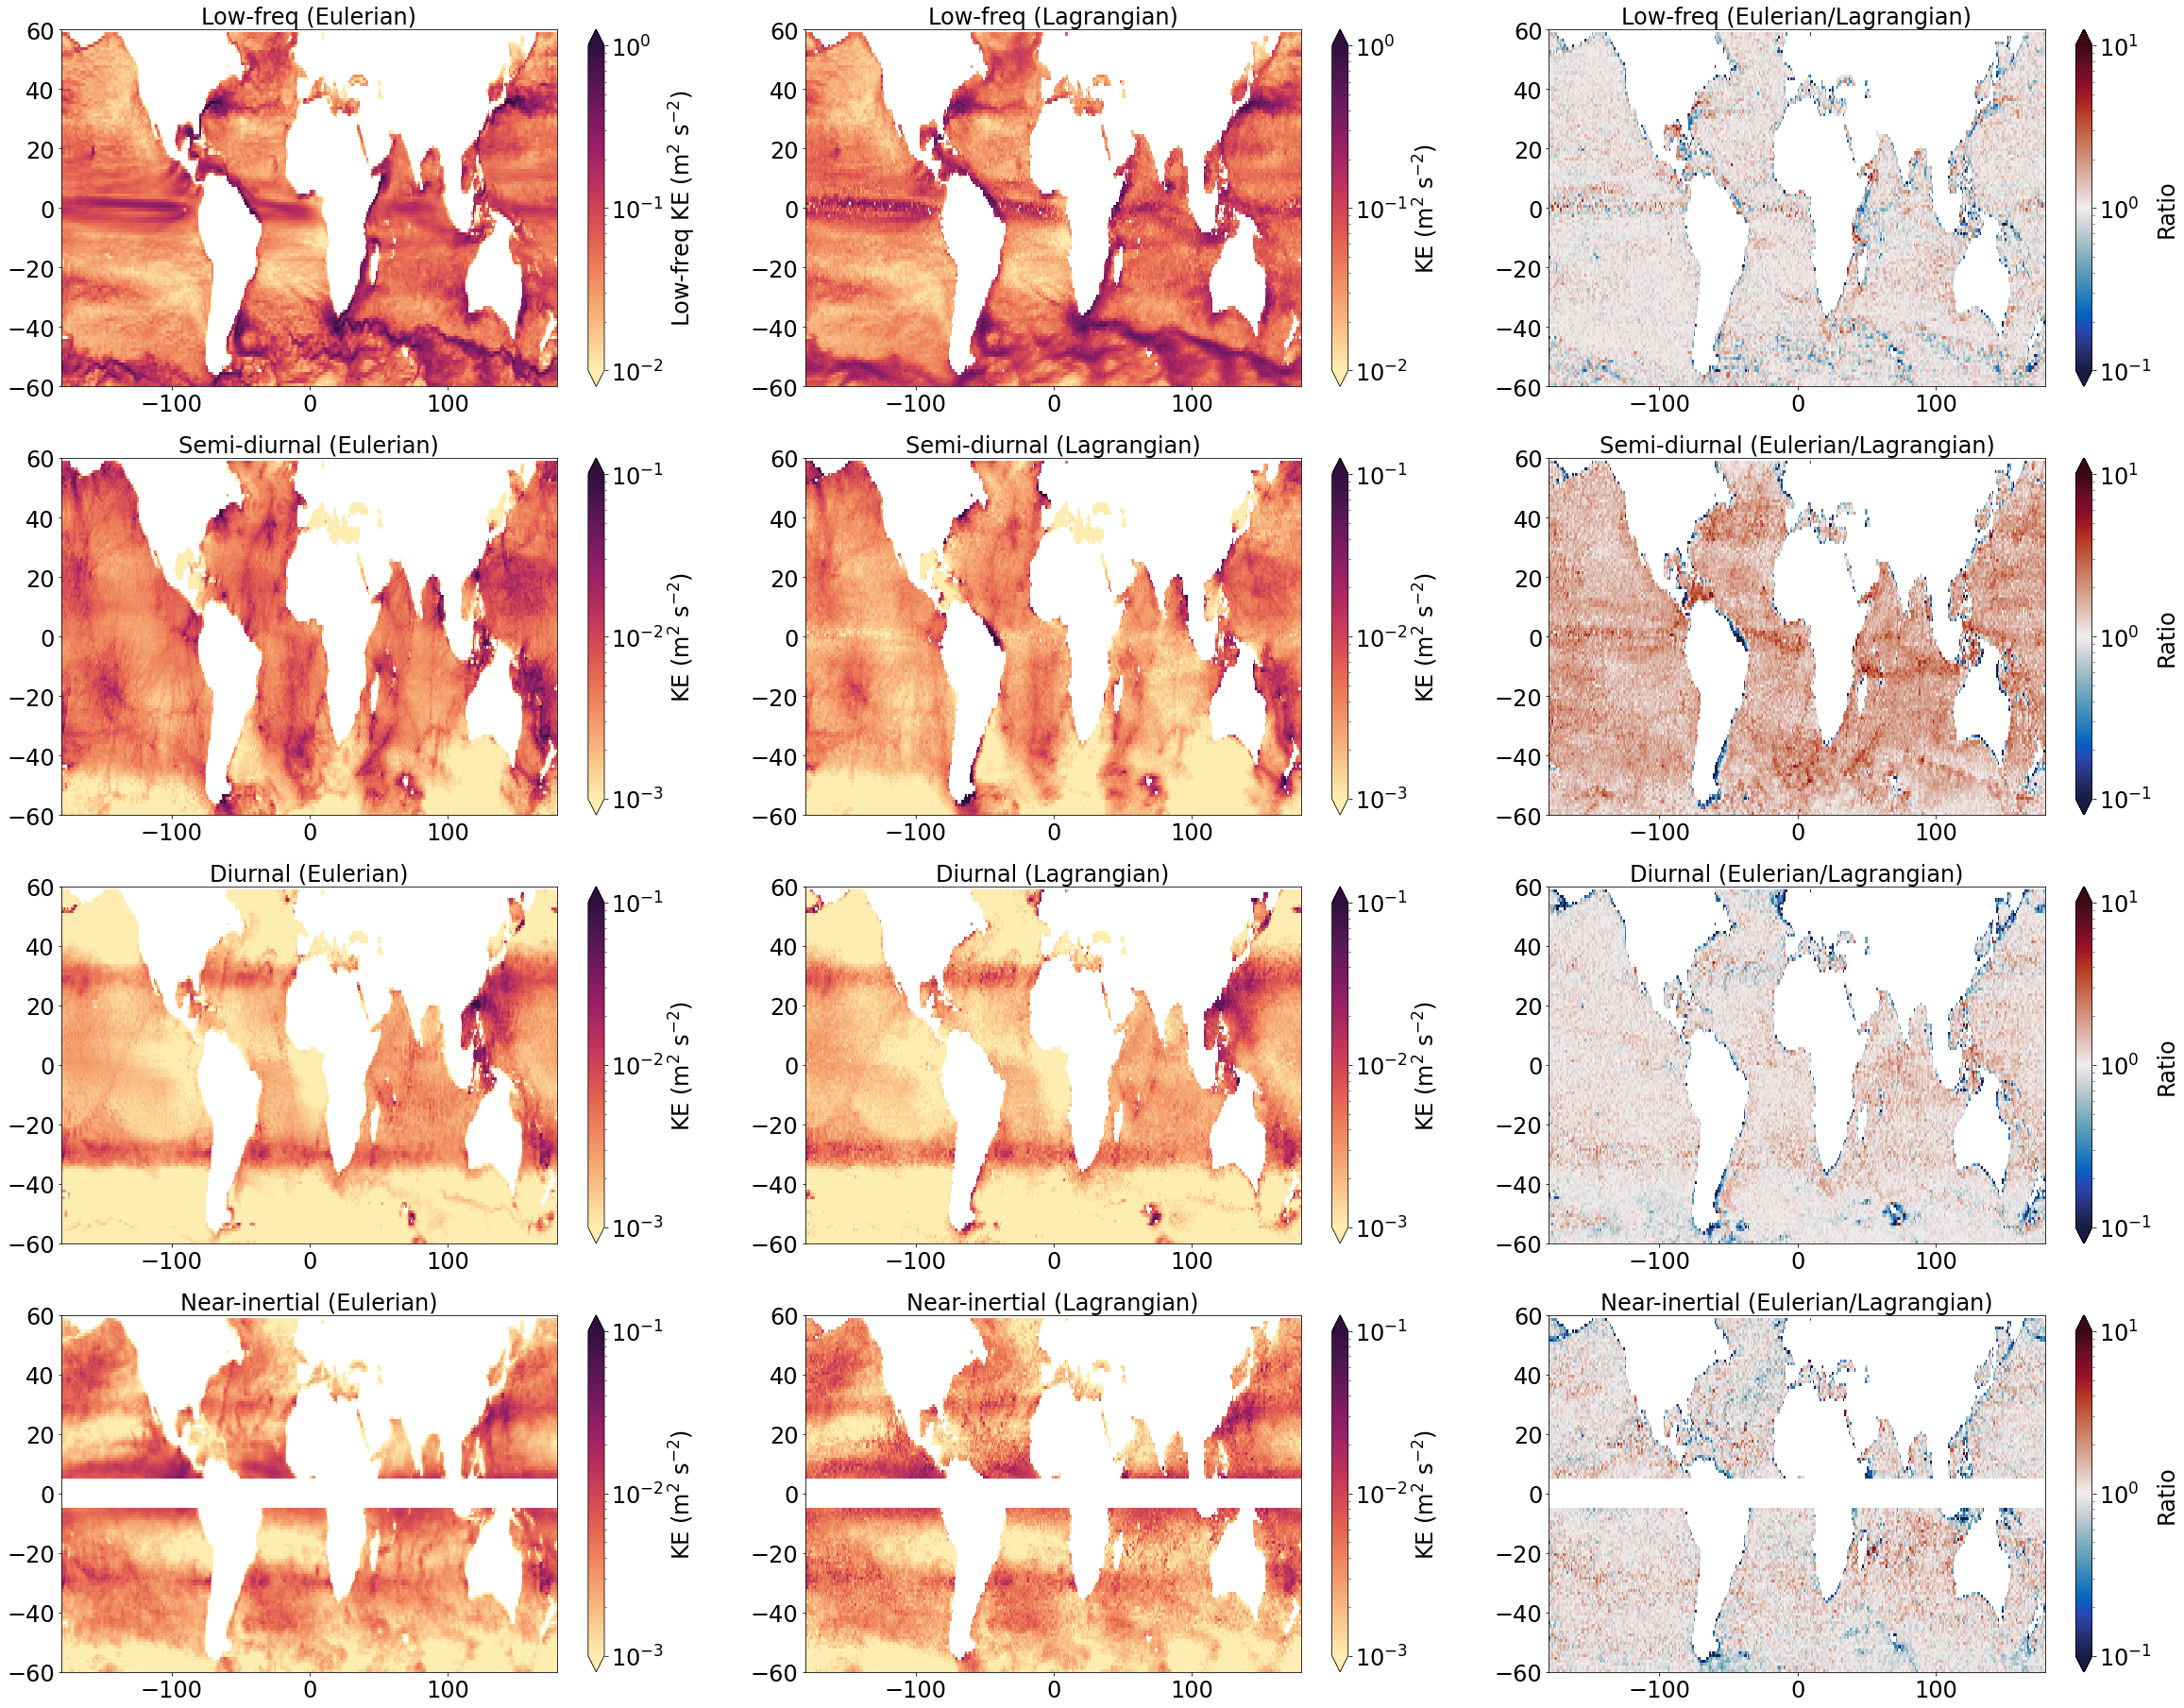

In [24]:
font_size = 24
fig, ax = plt.subplots(figsize=(40,32))

ax = plt.subplot(431)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='low')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-2, vmax=1e0), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Low-freq KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Low-freq (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(434)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='semidiurnal_0dot1')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(437)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='diurnal_0dot1')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Diurnal (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(4,3,10)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='inertial_0dot1').where(np.abs(E_Eulerian.lat_bins)>5)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Near-inertial (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)




ax = plt.subplot(432)
cax=(E_lagrangian.sel(frequency_band='low')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-2, vmax=1e0), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Low-freq (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(435)
cax=(E_lagrangian.sel(frequency_band='semidiurnal_0dot1')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(438)
cax=(E_lagrangian.sel(frequency_band='diurnal_0dot1')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Diurnal (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(4,3,11)
cax=(E_lagrangian.sel(frequency_band='inertial_0dot1').where(np.abs(E_lagrangian.lat_bins)>5)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Near-inertial (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)




ax = plt.subplot(433)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='low')/E_lagrangian.sel(frequency_band='low')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
ax.set_title('Low-freq (Eulerian/Lagrangian)',fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
cbar.set_label('Ratio', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(436)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='semidiurnal_0dot1')/E_lagrangian.sel(frequency_band='semidiurnal_0dot1')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(439)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='diurnal_0dot1')/E_lagrangian.sel(frequency_band='diurnal_0dot1')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Diurnal (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(4,3,12)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='inertial_0dot1')/E_lagrangian.sel(frequency_band='inertial_0dot1')).where(np.abs(E_Eulerian.lat_bins)>5).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Near-inertial (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)


#plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC.png')

Text(0.5, 0, '')

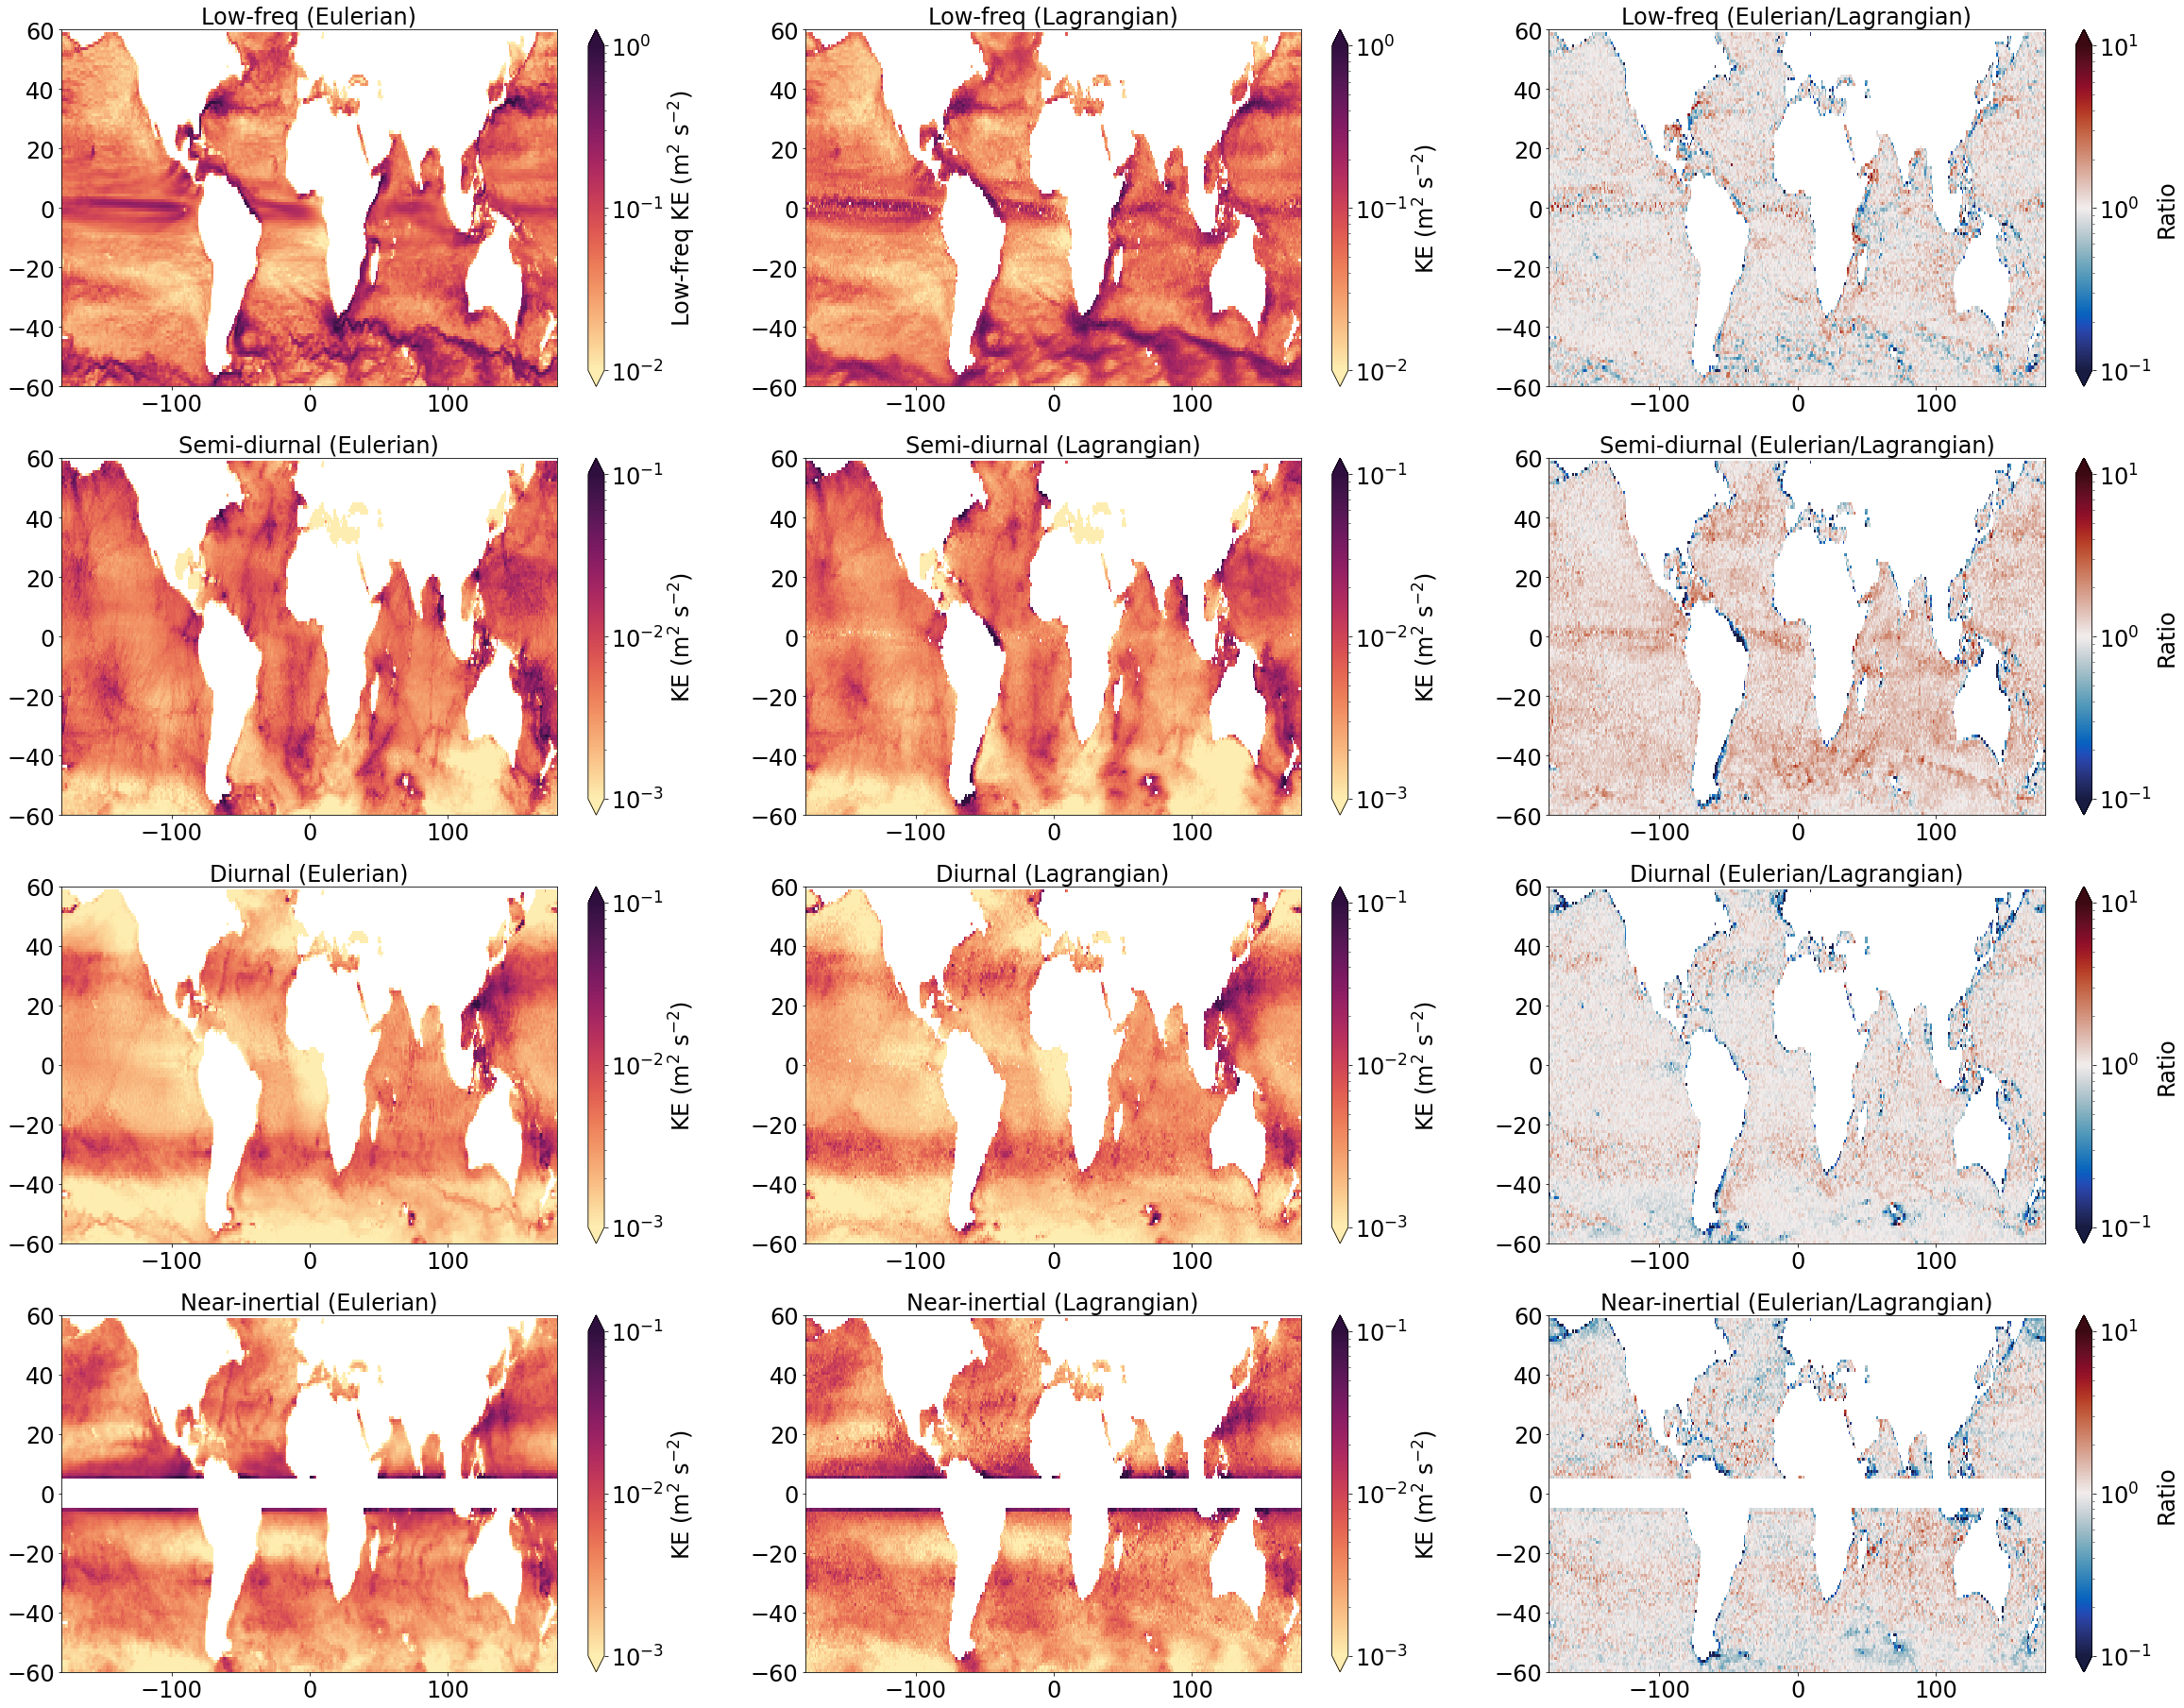

In [25]:
font_size = 24
fig, ax = plt.subplots(figsize=(40,32))

ax = plt.subplot(431)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='low')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-2, vmax=1e0), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Low-freq KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Low-freq (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(434)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='semidiurnal_0dot2')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(437)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='diurnal_0dot2')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Diurnal (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(4,3,10)
cax=(E_Eulerian.E_SSUV.sel(frequency_band='inertial_0dot2').where(np.abs(E_Eulerian.lat_bins)>5)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Near-inertial (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)




ax = plt.subplot(432)
cax=(E_lagrangian.sel(frequency_band='low')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-2, vmax=1e0), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Low-freq (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(435)
cax=(E_lagrangian.sel(frequency_band='semidiurnal_0dot2')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(438)
cax=(E_lagrangian.sel(frequency_band='diurnal_0dot2')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Diurnal (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(4,3,11)
cax=(E_lagrangian.sel(frequency_band='inertial_0dot2').where(np.abs(E_lagrangian.lat_bins)>5)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Near-inertial (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)




ax = plt.subplot(433)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='low')/E_lagrangian.sel(frequency_band='low')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
ax.set_title('Low-freq (Eulerian/Lagrangian)',fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
cbar.set_label('Ratio', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(436)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='semidiurnal_0dot2')/E_lagrangian.sel(frequency_band='semidiurnal_0dot2')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(439)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='diurnal_0dot2')/E_lagrangian.sel(frequency_band='diurnal_0dot2')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Diurnal (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(4,3,12)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='inertial_0dot2')/E_lagrangian.sel(frequency_band='inertial_0dot2')).where(np.abs(E_Eulerian.lat_bins)>5).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Near-inertial (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)


#plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC.png')

## Close cluster

In [6]:
cluster.close()